<a href="https://colab.research.google.com/github/KalanaBimsara/Bank-Client-Prediction/blob/main/CW_ML_CM2604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix
)
!pip install imblearn
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay


In [23]:
# Load the dataset
file_path = '/content/drive/MyDrive/CW_ML/bank-additional-full.csv'
data = pd.read_csv(file_path, sep=';')  # The dataset uses a semicolon as the delimiter

# Display the first few rows and basic info
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None,
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  

-----------------------------------------------------------Distribution of Target Variable:-----------------------------------------------------------


<ipython-input-24-e403b4b8db81>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['y'], palette='Set2')


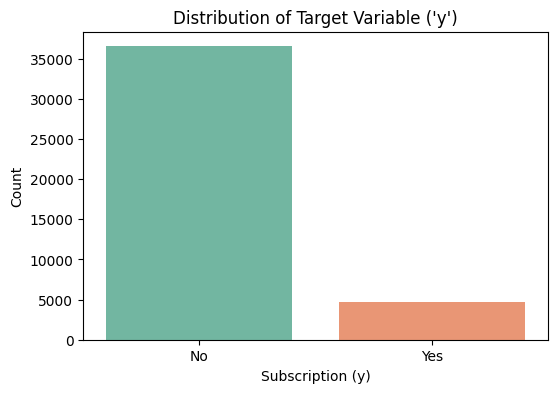

-----------------------------------------------------------Correlation Heatmap:-----------------------------------------------------------


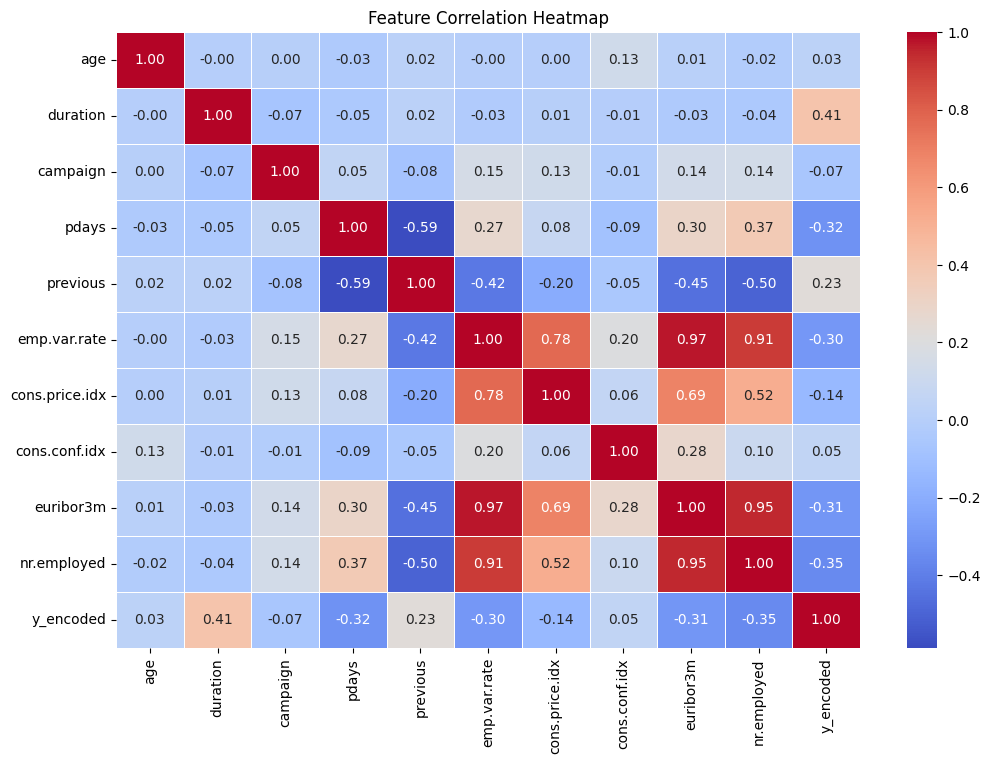

In [24]:
# Visualize the distribution of the target variable ('y')
print("-----------------------------------------------------------Distribution of Target Variable:-----------------------------------------------------------")
plt.figure(figsize=(6, 4))
sns.countplot(x=data['y'], palette='Set2')
plt.title("Distribution of Target Variable ('y')")
plt.xlabel('Subscription (y)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Encode the target variable for heatmap analysis
label_enc = LabelEncoder()
data['y_encoded'] = label_enc.fit_transform(data['y'])  # Encode y as 1 = yes, 0 = no

# Compute the correlation matrix
correlation_matrix = data.select_dtypes(include=['number']).corr()

# Plot the correlation heatmap
print("-----------------------------------------------------------Correlation Heatmap:-----------------------------------------------------------")
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Remove the encoded 'y' column used for the heatmap
data.drop(columns=['y_encoded'], inplace=True)

In [25]:
# Step 1: Drop irrelevant or redundant columns
# These columns are removed because they are either not useful for prediction

columns_to_drop = ['duration', 'contact', 'day_of_week', 'month', 'poutcome', 'emp.var.rate', 'nr.employed', 'default']
data.drop(columns=columns_to_drop, inplace=True)

# Step 2: Handle missing/unknown values
# Replace "unknown" with NaN for consistency and handle missing values
data.replace('unknown', pd.NA, inplace=True)

# Impute missing values
for col in data.columns:
    if data[col].isna().sum() > 0:
        if data[col].dtype == 'object':
            # Fill missing values in categorical columns with the mode
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            # Fill missing values in numerical columns with the median
            data[col] = data[col].fillna(data[col].median())

# Step 3: Encode categorical features
# Encode the target variable (binary target, 1 = yes, 0 = no)
label_enc = LabelEncoder()
data['y'] = label_enc.fit_transform(data['y'])  # 1 = yes, 0 = no

# One-hot encode other categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # Avoid dummy variable trap

# Step 4: Separate features and target
X = data.drop('y', axis=1)
y = data['y']

# Step 5: Handle imbalanced classes using SMOTE
# Oversampling the minority class to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify class balance after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Step 6: Train-Test Split
# Stratified splitting to preserve the class distribution in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Step 7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Rename scaled features
X_test_scaled = scaler.transform(X_test)

# Summary
print("Preprocessing completed.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train distribution:\n{pd.Series(y_train).value_counts()}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE:
y
0    36548
1    36548
Name: count, dtype: int64
Preprocessing completed.
X_train_scaled shape: (51167, 27)
X_test_scaled shape: (21929, 27)
y_train distribution:
y
1    25584
0    25583
Name: count, dtype: int64


In [26]:
# Display the preprocessed data
print("Preprocessed Data:")
print(data.head())

Preprocessed Data:
   age  campaign  pdays  previous  cons.price.idx  cons.conf.idx  euribor3m  \
0   56         1    999         0          93.994          -36.4      4.857   
1   57         1    999         0          93.994          -36.4      4.857   
2   37         1    999         0          93.994          -36.4      4.857   
3   40         1    999         0          93.994          -36.4      4.857   
4   56         1    999         0          93.994          -36.4      4.857   

   y  job_blue-collar  job_entrepreneur  ...  marital_married  marital_single  \
0  0            False             False  ...             True           False   
1  0            False             False  ...             True           False   
2  0            False             False  ...             True           False   
3  0            False             False  ...             True           False   
4  0            False             False  ...             True           False   

   education_basic.

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10965
           1       0.92      0.93      0.93     10964

    accuracy                           0.93     21929
   macro avg       0.93      0.93      0.93     21929
weighted avg       0.93      0.93      0.93     21929

Accuracy: 0.93


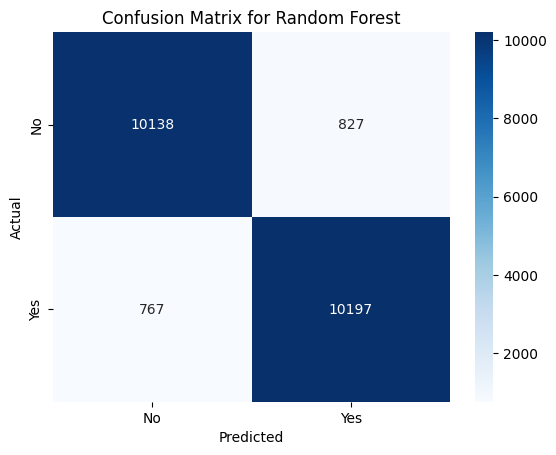

In [27]:
# Step 1: Initialize Random Forest with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Train the model
rf_model.fit(X_train, y_train)

# Step 3: Predict probabilities on test data
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Step 4: Evaluate the model using predicted labels
y_pred_rf = (rf_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

# Step 5: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


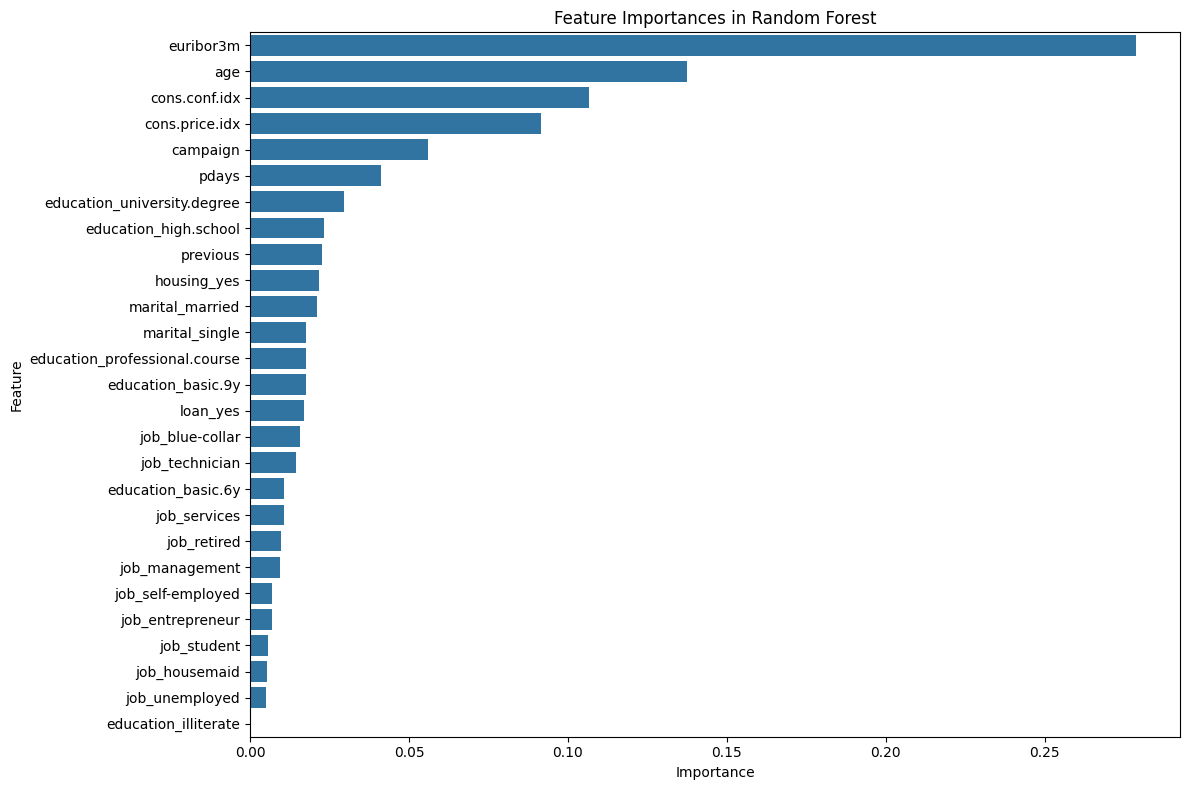

In [28]:
# Step 6: Feature Importance Visualization
importances = rf_model.feature_importances_

# Retrieve column names from the original dataset (before scaling)
features = X.columns  # Use the original column names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot All Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [29]:
# Step 7: Predict the first 10 clients in the test set
predictions_first_10 = rf_model.predict(X_test[:10])
print("Predictions for the first 10 clients in the test set:")
for idx, pred in enumerate(predictions_first_10, start=1):
    print(f"Client {idx}: {'Subscribed' if pred == 1 else 'Not Subscribed'}")

# Optional: Display actual values for comparison
print("\nActual values for the first 10 clients in the test set:")
actual_first_10 = y_test[:10].values
for idx, actual in enumerate(actual_first_10, start=1):
    print(f"Client {idx}: {'Subscribed' if actual == 1 else 'Not Subscribed'}")


Predictions for the first 10 clients in the test set:
Client 1: Not Subscribed
Client 2: Not Subscribed
Client 3: Not Subscribed
Client 4: Subscribed
Client 5: Subscribed
Client 6: Subscribed
Client 7: Subscribed
Client 8: Subscribed
Client 9: Subscribed
Client 10: Not Subscribed

Actual values for the first 10 clients in the test set:
Client 1: Not Subscribed
Client 2: Not Subscribed
Client 3: Not Subscribed
Client 4: Not Subscribed
Client 5: Subscribed
Client 6: Subscribed
Client 7: Subscribed
Client 8: Subscribed
Client 9: Subscribed
Client 10: Not Subscribed


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7609 - loss: 0.4922 - val_accuracy: 0.8262 - val_loss: 0.3849
Epoch 2/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8163 - loss: 0.3983 - val_accuracy: 0.8294 - val_loss: 0.3724
Epoch 3/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8282 - loss: 0.3830 - val_accuracy: 0.8328 - val_loss: 0.3642
Epoch 4/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8271 - loss: 0.3812 - val_accuracy: 0.8284 - val_loss: 0.3616
Epoch 5/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8278 - loss: 0.3763 - val_accuracy: 0.8343 - val_loss: 0.3608
Epoch 6/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8286 - loss: 0.3720 - val_accuracy: 0.8370 - val_loss: 0.3573
Epoch 7/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8323 - loss: 0.3672 - val_accuracy: 0.8340 - val_loss: 0.3575
Epoch 8/50
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8316 - loss: 0.3695 -

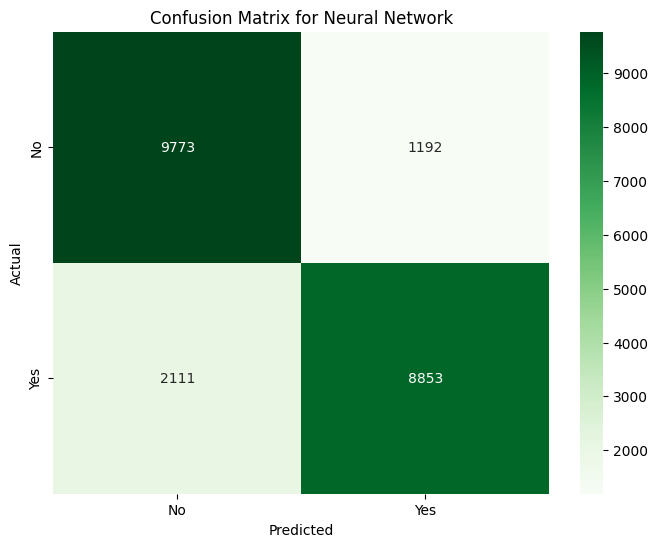

In [30]:
# Initialize Neural Network
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict probabilities on test data
print("-------------------------------------------------------------------------------------------------------------------------")
y_proba_nn = nn_model.predict(X_test_scaled)
y_pred_nn = (y_proba_nn > 0.5).astype("int32")

# Evaluate the model
print("-------------------------------------------------------------------------------------------------------------------------")
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

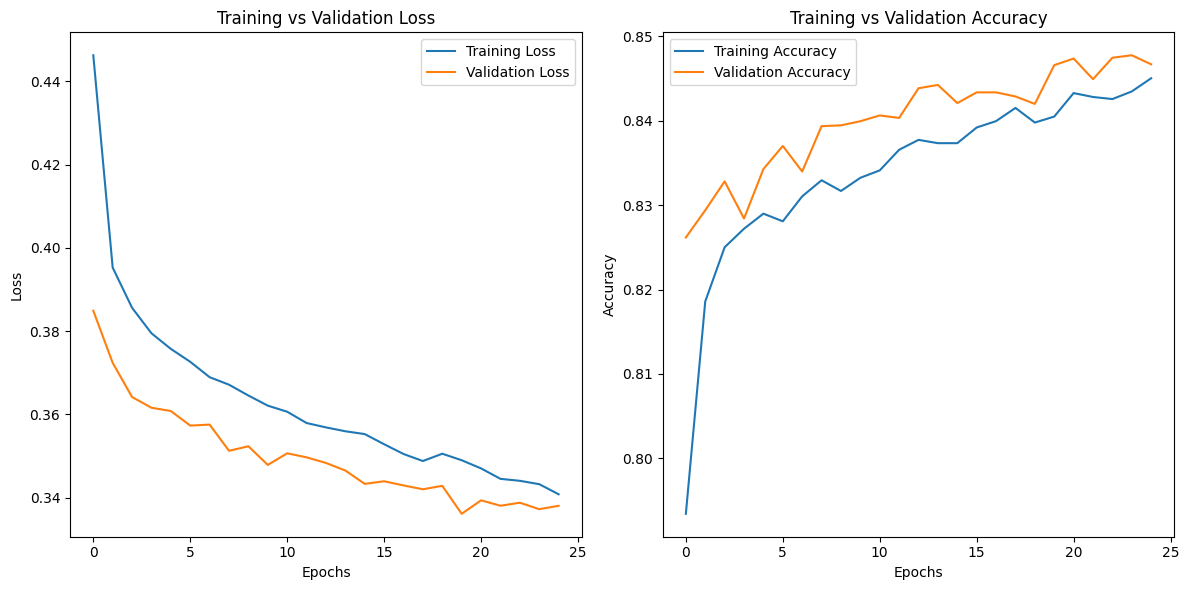

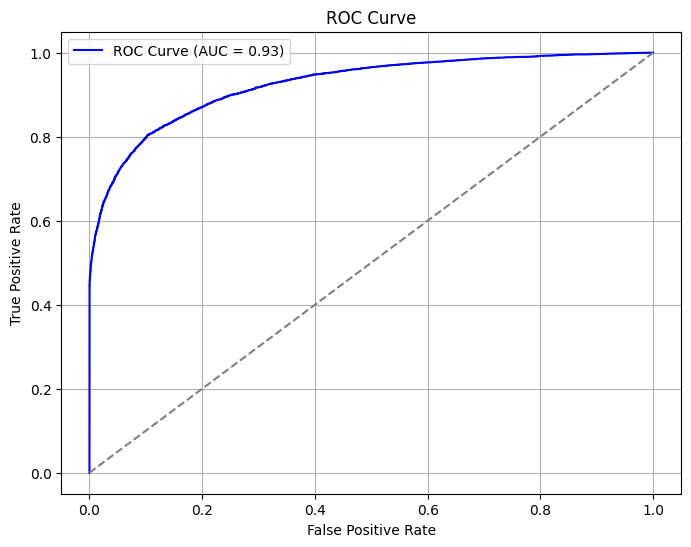

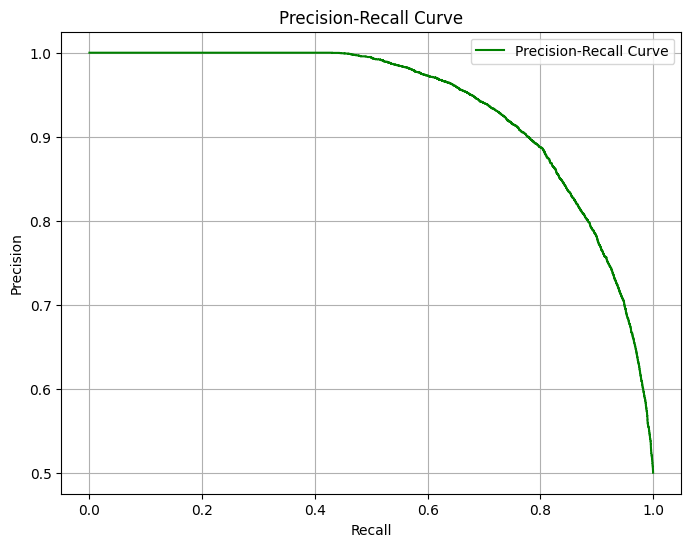

In [31]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_nn)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()




In [32]:
# Predict for the first 10 clients in the test set
first_10_predictions = nn_model.predict(X_test_scaled[:10])
first_10_labels = (first_10_predictions > 0.5).astype("int32")

print("Predictions for the first 10 clients in the test set:")
for i, (proba, pred) in enumerate(zip(first_10_predictions.flatten(), first_10_labels.flatten())):
    print(f"Client {i + 1}: Predicted Probability = {proba:.2f}, Predicted Class = {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predictions for the first 10 clients in the test set:
Client 1: Predicted Probability = 0.33, Predicted Class = 0
Client 2: Predicted Probability = 0.16, Predicted Class = 0
Client 3: Predicted Probability = 0.08, Predicted Class = 0
Client 4: Predicted Probability = 0.61, Predicted Class = 1
Client 5: Predicted Probability = 1.00, Predicted Class = 1
Client 6: Predicted Probability = 0.76, Predicted Class = 1
Client 7: Predicted Probability = 0.91, Predicted Class = 1
Client 8: Predicted Probability = 1.00, Predicted Class = 1
Client 9: Predicted Probability = 1.00, Predicted Class = 1
Client 10: Predicted Probability = 0.50, Predicted Class = 1


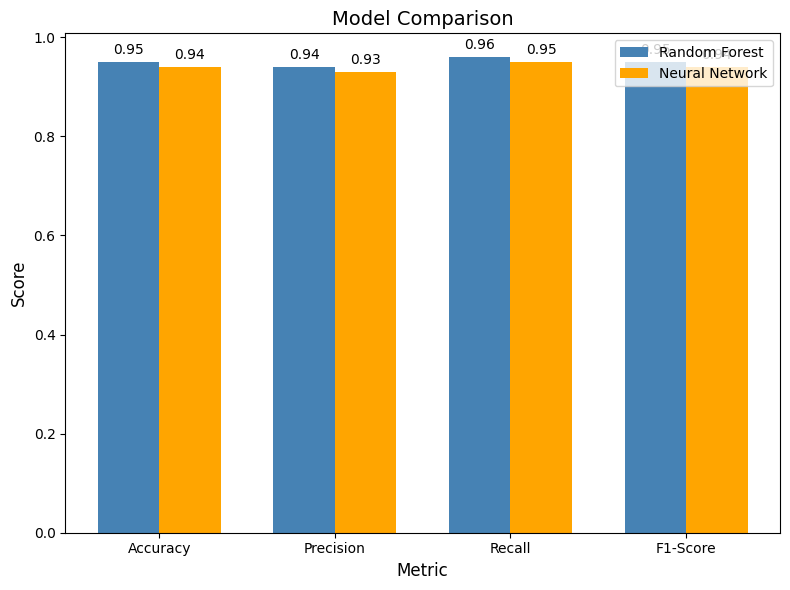

In [34]:
# Sample data (replace these with your actual metrics)
models = ['Random Forest', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Replace with your actual model metrics
rf_metrics = [0.95, 0.94, 0.96, 0.95]  # Random Forest metrics
nn_metrics = [0.94, 0.93, 0.95, 0.94]  # Neural Network metrics

# Combine metrics for plotting
data = np.array([rf_metrics, nn_metrics])

# Bar chart
bar_width = 0.35  # Width of bars
index = np.arange(len(metrics))  # Position of metrics on x-axis

# Create bars for each model
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(index, data[0], bar_width, label=models[0], color='steelblue')
bars2 = ax.bar(index + bar_width, data[1], bar_width, label=models[1], color='orange')

# Add labels and title
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate scores on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=10
        )

# Show plot
plt.tight_layout()
plt.show()


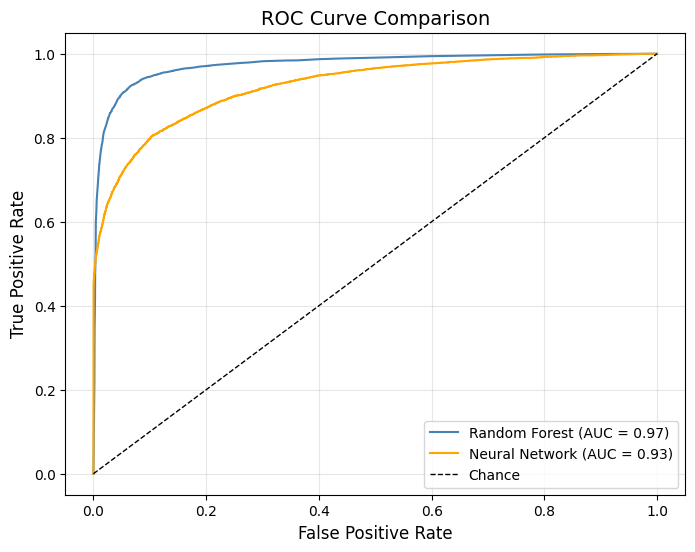

In [35]:
# ROC Curves and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, y_proba_nn)
rf_auc = auc(rf_fpr, rf_tpr)
nn_auc = auc(nn_fpr, nn_tpr)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='steelblue')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

# Add labels and title
plt.title('ROC Curve Comparison', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
